In [60]:
# cases = [1, 1, 1, 1, 6, 6, 6, 9, 9, 15, 19, 24, 33, 33, 53, 56, 86, 98, 131, 137, 191, 262, 290, 410, 546, 703, 817, 1014, 1226, 1613, 1880, 2475, 2923, 3357, 3893, 4484, 5181, 5841, 6698, 7822, 8852, 10158, 11513, 13002, 14776, 16146, 18105, 20754, 24324, 26350, 29433, 31981, 33940, 36897, 39509, 42480, 45351, 48426, 50646, 53739, 57300, 62658, 68606, 74401, 80115, 85973, 92676, 98522]

In [139]:
# importing required modules

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# setting plot parameters

plt.ion()
plt.rcParams['figure.figsize'] = 10, 8

In [140]:
# setting known disease parameters

sigma = 5.1 # mean incubation period
eta = 3.5 # avg time between symptoms and hospitalization
delta = 14.68 # avg time between hospitalization and death
gamma = 11.36 # avg curation time (with symptoms)
lmbda = 11.36 # avg curation time (no symptoms)
mu = 0.88 # amount of non-symptom cases
xi = 3 # mean time between end of incub. period and detection of a virus

На данный момент неизвестны два параметра:


1) $\beta$ — infection rate


2) $\rho$ — mortality rate

Предлагается разбить наблюдаемый период на группы. 

Будем считать, что 24.02.2020
в Москве появился первый заболевший $\in \text { } Infectious$

(27.02 он обратился за мед. помощью, среднее время
от конца инкуб. периода до выявления вируса = 3 дня)

Таким образом, наблюдается период с 24.02 до 8.05. 

31.03 в Москве была введена самоизоляция, это одна из ключевых дат. 

Так, период разбивается на два: с 24.02 до 30.03 и с 31.03 до 8.05.

Первый период разобьём на 5 семидневных промежутков.

Второй период разобьём также на 5 недельных промежутков (таким образом, последний закончится 5 мая)

Для каждого из промежутков при помощи метода наименьших квадратов аппроксимируем $\beta \text{ и } \rho$

Далее построим для каждого из параметров линейную регрессию, и с полученными значениями $\beta \text{ и } \rho$ дадим прогноз на период 6-12.05

Первые две недели посчитаем вместе, потому что там было маленькое количество тестов. Если фиттить по неделям, есть шанс получить beta = 0 в самом начале (и, соответственно, вымирание эпидемии, что не произошло)

In [150]:
# defining the system of ODE 

def f(y, t, beta, rho):
    Xi = y[0] # susceptible
    Vi = y[1] # exposed
    Qi = y[2] # infectious
    Wi = y[3] # non-symptomatical
    Yi = y[4] # symptomatical (non-hospitalized)
    Ui = y[5] # hospitalized
    Zi = y[6] # removed
    Di = y[7] # dead
    f0 = -beta * Xi * Qi / N
    f1 = beta * Xi * Qi / N - (1 / sigma) * Vi
    f2 = (1 / sigma) * Vi - (1 / xi) * Qi
    f3 = (1 / xi) * mu * Qi - (1 / lmbda) * Wi
    f4 = (1 / xi) * (1 - mu) * Qi - 0.87 * (1 / gamma) * Yi - 0.13 * (1 / eta) * Yi
    f5 = 0.13 * (1 / eta) * Yi - (1 / gamma) * Ui / (1 - rho)
    f6 = (1 / lmbda) * Wi + 0.87 * (1 / gamma) * Yi + (1 / gamma) * Ui
    f7 = rho / (1 - rho) * Ui
    return [f0, f1, f2, f3, f4, f5, f6, f7]


# implementing error func
# cases is a 1D-array containing info about reported cases during the period
# inp is a 1-D array containing initial state of the system
from functools import partial

def error_1stp(b, r, cases, inp):
    err = 0
    t = np.linspace(0, 13, 490 * 2)
    f2 = partial(f, beta=b, rho=r)
    soln = odeint(f2, inp, t)
    W = soln[:, 3]
    Y = soln[:, 4]
    U = soln[:, 5]
    Z = soln[:, 6]
    for i in range(1, 15):
        forecast_cases = W[i * 70 - 1] + Y[i * 70 - 1] + U[i * 70 - 1] + Z[i * 70 - 1]
        to_sum = (forecast_cases - cases[i - 1]) ** 2
        err += to_sum
    return err

def error(b, r, cases, inp):
    err = 0
    t = np.linspace(0, 6, 490)
    f2 = partial(f, beta=b, rho=r)
    soln = odeint(f2, inp, t)
    W = soln[:, 3]
    Y = soln[:, 4]
    U = soln[:, 5]
    Z = soln[:, 6]
    for i in range(1, 8):
        forecast_cases = W[i * 70 - 1] + Y[i * 70 - 1] + U[i * 70 - 1] + Z[i * 70 - 1]
        to_sum = (forecast_cases - cases[i - 1]) ** 2
        err += to_sum
    return err

Запустим перебор по значениям $\beta \text{ и } \rho$ с шагом 0.01

Будем считать, что $\beta \in [0.4, 1.5]; \rho \in [0.5, 1]$

In [168]:
def fit_beta_1stp(week, inp):

    best_beta = 0
    best_error = 10e6
    for i in range(40, 400):
        beta = i / 100
        current_beta_error= error_1stp(beta, 0.8, cases[week * 7:(week+2)*7], inp)
        if current_beta_error < best_error:
            best_beta = beta
            best_error = current_beta_error
    return best_beta, best_error


def fit_beta(week, inp):

    best_beta = 0
    best_error = 10e6
    for i in range(40, 400):
        beta = i / 100
        current_beta_error= error(beta, 0.8, cases[week * 7:(week+1)*7], inp)
        if current_beta_error < best_error:
            best_beta = beta
            best_error = current_beta_error
    return best_beta, best_error

In [182]:
N = 12537954 # moscow population 
X_0 = N - 1
V_0 = 0
Q_0 = 1
W_0 = 0
Y_0 = 0
U_0 = 0
Z_0 = 0
D_0 = 0
y0 = [X_0, V_0, Q_0, W_0, Y_0, U_0, Z_0, D_0]
x, err = fit_beta_1stp(0, y0)
print(x)

0.82


In [183]:
betas = list()
for i in range(4):
    if i == 0:
        x, err = fit_beta_1stp(0, y0)
        t = np.linspace(0, 13, 490 * 2)
        soln = odeint(partial(f, beta=x, rho=0.8), y0, t)
        y0 = [soln[:, 0][979], soln[:, 1][979], soln[:, 2][979], soln[:, 3][979], soln[:, 4][979], soln[:, 5][979], soln[:, 6][979], soln[:, 7][979]]
        betas.append(x)
    else:
        x, err = fit_beta(i + 1, y0)
        t = np.linspace(0, 6, 490 * 2)
        soln = odeint(partial(f, beta=x, rho=0.8), y0, t)
        y0 = [soln[:, 0][979], soln[:, 1][979], soln[:, 2][979], soln[:, 3][979], soln[:, 4][979], soln[:, 5][979], soln[:, 6][979], soln[:, 7][979]]
        betas.append(x)
    print("Step number {}: beta = {}, error = {}\n".format(i + 1, x, err))

Step number 1: beta = 0.82, error = 27.387040146043972

Step number 2: beta = 3.49, error = 214.7195272904078

Step number 3: beta = 0.2, error = 9794.572927843734

Step number 4: beta = 3.03, error = 42202.933523594125



Какая-то неадекватная хуйня. Я устал, завтра разберусь

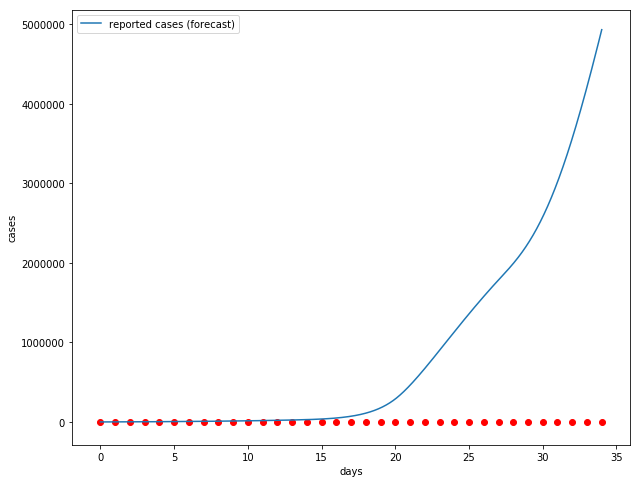

In [176]:
def f_graph(y, t):
    if t <= 13:
        beta = 0.82
    elif t <= 20:
        beta = 3.49
    elif t <= 27:
        beta = 0.2
    else:
        beta = 3.03
    rho = 0.4
    Xi = y[0] # susceptible
    Vi = y[1] # exposed
    Qi = y[2] # infectious
    Wi = y[3] # non-symptomatical
    Yi = y[4] # symptomatical (non-hospitalized)
    Ui = y[5] # hospitalized
    Zi = y[6] # removed
    Di = y[7] # dead
    f0 = -beta * Xi * Qi / N
    f1 = beta * Xi * Qi / N - (1 / sigma) * Vi
    f2 = (1 / sigma) * Vi - (1 / xi) * Qi
    f3 = (1 / xi) * mu * Qi - (1 / lmbda) * Wi
    f4 = (1 / xi) * (1 - mu) * Qi - 0.87 * (1 / gamma) * Yi - 0.13 * (1 / eta) * Yi
    f5 = 0.13 * (1 / eta) * Yi - (1 / gamma) * Ui / (1 - rho)
    f6 = (1 / lmbda) * Wi + 0.87 * (1 / gamma) * Yi + (1 / gamma) * Ui
    f7 = rho / (1 - rho) * Ui
    return [f0, f1, f2, f3, f4, f5, f6, f7]
t = np.linspace(0, 34, 490 * 5)
soln = odeint(f_graph, y0, t)
X = soln[:, 0]
V = soln[:, 1]
Q = soln[:, 2]
W = soln[:, 3]
Y = soln[:, 4]
U = soln[:, 5]
Z = soln[:, 6]
D = soln[:, 7]
plt.plot(t, W + Y + U + Z, label='reported cases (forecast)')
plt.xlabel('days')
plt.ylabel('cases')
plt.legend(loc=0)
for i in range(35):
    plt.scatter(i, cases[i], color='red')